# Policy Gradient Method

## Gym

In [1]:
import gym
from gym import envs

envs.registry.all()

ValuesView(├──CartPole: [ v0, v1 ]
├──MountainCar: [ v0 ]
├──MountainCarContinuous: [ v0 ]
├──Pendulum: [ v1 ]
├──Acrobot: [ v1 ]
├──LunarLander: [ v2 ]
├──LunarLanderContinuous: [ v2 ]
├──BipedalWalker: [ v3 ]
├──BipedalWalkerHardcore: [ v3 ]
├──CarRacing: [ v1 ]
├──Blackjack: [ v1 ]
├──FrozenLake: [ v1 ]
├──FrozenLake8x8: [ v1 ]
├──CliffWalking: [ v0 ]
├──Taxi: [ v3 ]
├──Reacher: [ v2 ]
├──Pusher: [ v2 ]
├──InvertedPendulum: [ v2 ]
├──InvertedDoublePendulum: [ v2 ]
├──HalfCheetah: [ v2, v3 ]
├──Hopper: [ v2, v3 ]
├──Swimmer: [ v2, v3 ]
├──Walker2d: [ v2, v3 ]
├──Ant: [ v2, v3 ]
├──Humanoid: [ v2, v3 ]
└──HumanoidStandup: [ v2 ]
)

In [2]:
env = gym.make("CartPole-v1")
state = env.reset()
state, type(state)

/Users/alextanhongpin/Library/Caches/pypoetry/virtualenvs/python-deep-reinforcement-learning-in-acti-HlKDIbnR-py3.12/lib/python3.12/site-packages/pygame/pkgdata.py:25: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from pkg_resources import resource_stream, resource_exists


(array([ 0.01369742,  0.00104424, -0.03528991, -0.0063105 ], dtype=float32),
 numpy.ndarray)

In [3]:
action = env.action_space.sample()
action, env.action_space

(1, Discrete(2))

In [4]:
state, reward, done, info = env.step(action)
state, reward, done, info

(array([ 0.0137183 ,  0.19665407, -0.03541612, -0.30991563], dtype=float32),
 1.0,
 False,
 {})

## REINFORCE

In [5]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from tqdm.notebook import trange

plt.rcParams["figure.figsize"] = (14, 6)

In [6]:
def make_model():
    model = torch.nn.Sequential(
        torch.nn.Linear(4, 64),
        torch.nn.LeakyReLU(),
        # There is only two output action, 0 or 1
        torch.nn.Linear(64, 2),
        torch.nn.Softmax(),
    )
    return model

In [7]:
model = make_model()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [8]:
def discount_rewards(rewards, gamma=0.99):
    returns = torch.pow(gamma, torch.arange(len(rewards))) * rewards
    return returns / returns.max()

In [9]:
discount_rewards(torch.Tensor([1, 2, 3, 4, 5]))

tensor([0.2082, 0.4122, 0.6122, 0.8081, 1.0000])

In [10]:
discount_rewards(torch.Tensor([1, 2, 3, 4, 5]).flip(dims=(0,)))

tensor([1.0000, 0.7920, 0.5881, 0.3881, 0.1921])

In [11]:
discount_rewards(torch.Tensor([1, 1, 1, 1, 1]))

tensor([1.0000, 0.9900, 0.9801, 0.9703, 0.9606])

In [12]:
def reinforce(model, optimzer, max_episodes=1000, max_trajectory=500, gamma=0.99):
    env = gym.make("CartPole-v1")
    scores = []
    for episode in trange(max_episodes):
        observation = env.reset()
        transitions = []

        for t in range(max_trajectory):
            state = torch.from_numpy(observation)
            action_probs = model(state)
            action = torch.multinomial(action_probs, 1)
            observation, reward, done, _info = env.step(action.item())
            transitions.append((state, action, reward + t))
            if done:
                break
        scores.append(len(transitions))

        state_batch, action_batch, reward_batch = list(zip(*transitions))
        state_batch = torch.stack(state_batch)
        action_batch = torch.stack(action_batch)
        reward_batch = torch.Tensor(reward_batch).flip(dims=(0,))

        pred_batch = model(state_batch)
        prob_batch = pred_batch.gather(dim=1, index=action_batch).squeeze()
        disc_batch = discount_rewards(reward_batch)

        loss = -torch.sum(disc_batch * torch.log(prob_batch))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    return scores

  0%|          | 0/1000 [00:00<?, ?it/s]

/Users/alextanhongpin/Library/Caches/pypoetry/virtualenvs/python-deep-reinforcement-learning-in-acti-HlKDIbnR-py3.12/lib/python3.12/site-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Text(0, 0.5, 'Episode duration')

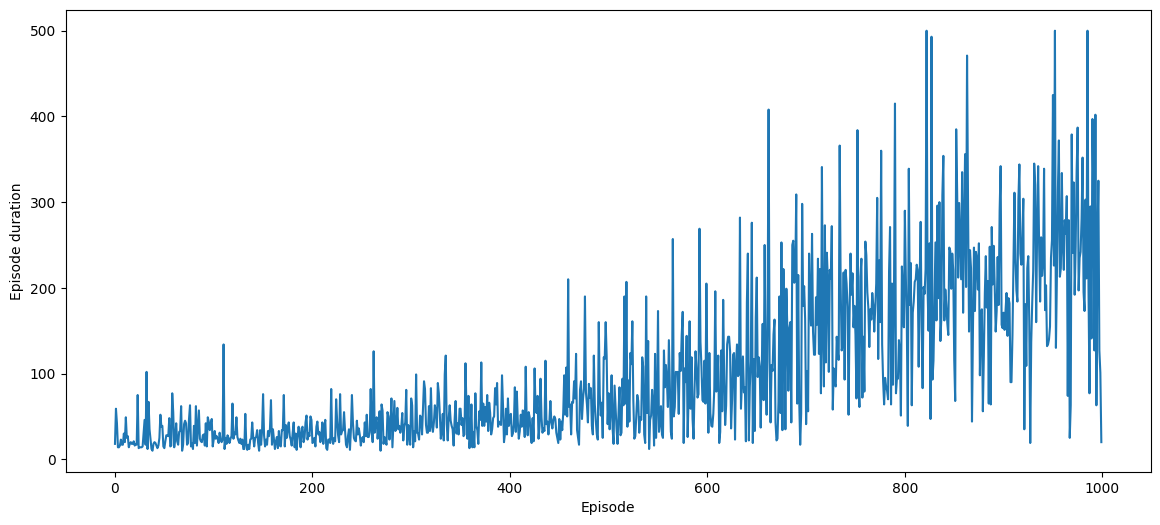

In [13]:
scores = reinforce(model, optimizer)
fig, ax = plt.subplots()
ax.plot(np.arange(len(scores)), scores)
ax.set_xlabel("Episode")
ax.set_ylabel("Episode duration")

In [14]:
def test_reinforce(model, max_episodes=1000, max_trajectory=1000):
    env = gym.make("CartPole-v1")
    scores = []
    for episode in trange(max_episodes):
        observation = env.reset()
        transitions = []

        for t in range(max_trajectory):
            state = torch.from_numpy(observation)
            with torch.no_grad():
                action_probs = model(state)
            action = torch.multinomial(action_probs, 1)
            observation, reward, done, _info = env.step(action.item())
            transitions.append((state, action, t + 1))
            if done:
                break
        scores.append(len(transitions))
    return scores

  0%|          | 0/1000 [00:00<?, ?it/s]

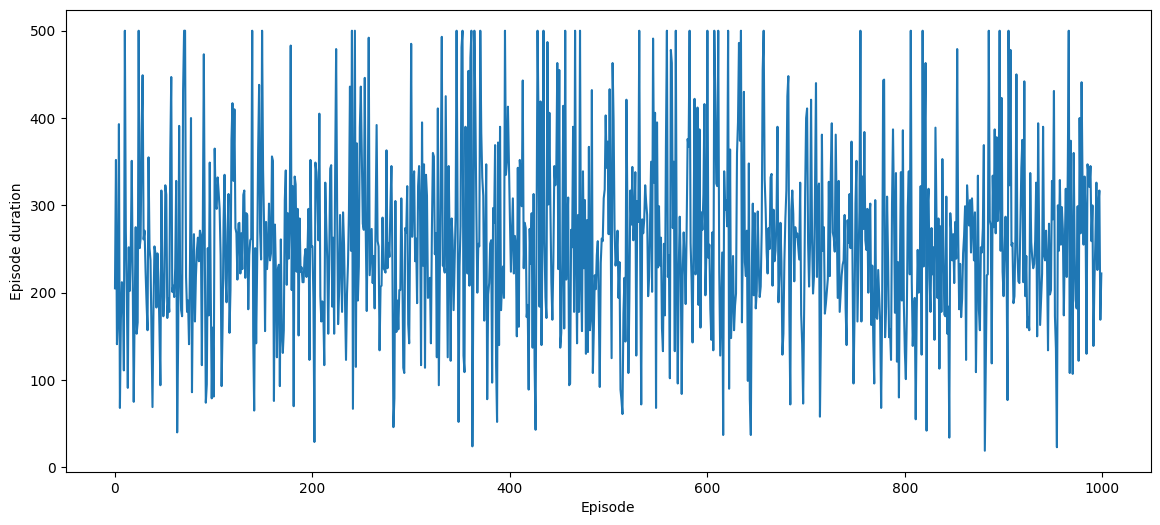

In [15]:
scores = test_reinforce(model)

fig, ax = plt.subplots()
ax.plot(np.arange(len(scores)), scores)
ax.set_xlabel("Episode")
ax.set_ylabel("Episode duration");

In [16]:
np.mean(scores), np.min(scores), np.max(scores)

(258.547, 19, 500)

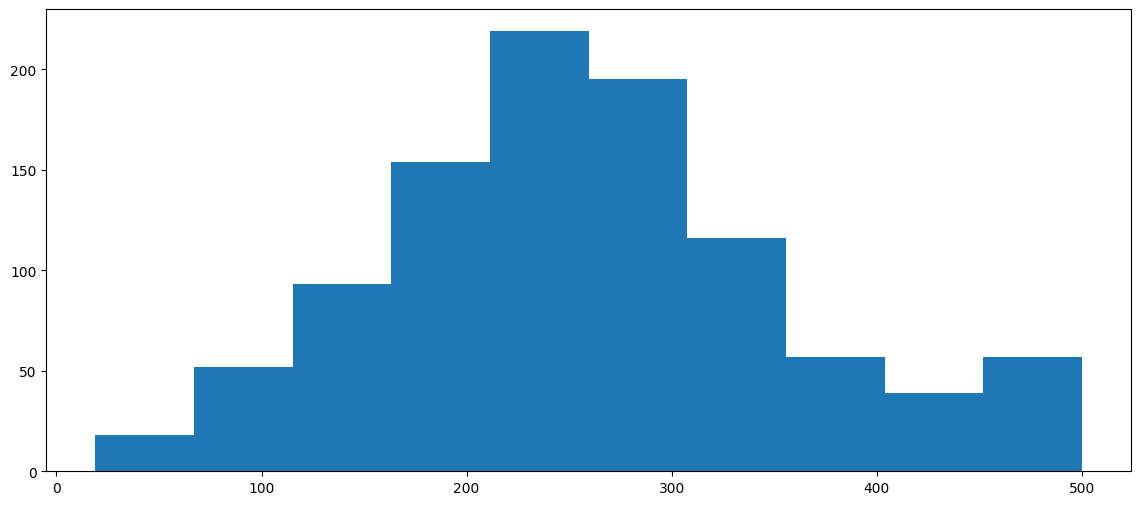

In [17]:
plt.hist(scores);